# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of coupling parameters that describe the interaction between different Bloch waves in the basis. At each value of $(k_x,k_y)$, the energy levels can be obtained by diagonalizing the Hamiltonian matrix and finding its eigenvalues. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,...

Right now, this package allows you to infer the coupling parameters in a 5 basis model: 5 Bloch waves at $\Gamma$ point and its four surrounding symmetric points in $k-$space, whoses interaction can be described by 6 coupling parameters.

![title](./reference_img/5-basis-doodle.png)

$U_{10},U_{11}$ and $U_{20}$ represent couplings between Bloch waves at different $k$ points, $\epsilon_0$ being the energy of the Bloch wave at the $\Gamma$ point, $\epsilon_x$ being the energy of other Bloch waves along $k_x$, $\epsilon_y$ being the energy of other Bloch waves along $k_y$. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_0,e_1,e_2,e_3,e_4\}$. 

From the measurement data, the energy mode at $\Gamma$ point is always too weak to detect. Therefore, one can simplify the model further to include basis of 4 k-vectors $\{P_2,P_3,P_4,P_5\}$ only. Our reduced Hamiltonian matrix becomes 
$$ H_{reduced} =  \begin{pmatrix} \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

And the eigenvalues $\{e_1,e_2,e_3,e_4\}$ represent 4 energy bands of the photonic crystal.

### Multiple Gaussian Peak Model of the energy spectrum

In real measurement, 4 energy bands of the photonic crystals appear as four peaks in the frequency-intensity line plot. Therefore, our model for the energy spectrum is a multiple Gaussian peak model where the peak positions are $\{e_1,e_2,e_3,e_4\}$.  The background $A_0$, amplitudes of four peaks $A_1, A_2, A_3, A_4$ and the peak width $\sigma_L$ are the nuisance parameters that we will marginalize over.

$$ y_{predicted} = A_0 + \sum_1^4 A_i \text{ Normal}(e_i, \sigma_L)$$

Firstly, we need to choose the priors for the parameters. For the coupling parameters $U_{11}$ and $U_{20}$, we know their lower and upper bounds from previous experiments (Reference ?). For the peak background and amplitudes, they are bounded by zero and the saturated intensity of the CCD detector. For the peak width, it is also bounded by the resolution in frequency of the laser and (?)  Since other these bounds we don't have any other information about the distributions of these parameters, in this package, we used uniform priors for all parameters.

$$\theta_n \sim \text{Uniform} (\theta_{n,min},\theta_{n,max})$$

for $\theta_n$ in $\{U_{11}, U_{20}, A_0, A_1, A_2, A_3, A_4, \sigma_L \}$. Note that for the uncoupling energies $\epsilon_x$ and $\epsilon_y$, we can extract their exact values from the (reference?) and use them as prior information.

Secondly, we consider all the uncertainty sources in measuring the light intensity such as beam profile, CCD sensitivity,...(?) These uncertainties are all Gaussian-like, thus, our likelihood is also well-described by Gaussian distribution:

$$y \sim \text{Gaussian} (y_{predicted}, \sigma_y)$$

## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the $\textbf{load_data(filename)}$ function which exports the data in .nc format into an xarray with three data labels 'normf', 'spectrum', 'spectrum_std'.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor

from photonic_hamiltonian import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\expdata_singleKspectrum.nc')

We can plot this data to visualize how the four peaks look like in a real measurement

Text(0.5, 1.0, 'Example data showing four energy bands of a single C4-symmetric photonic crystal')

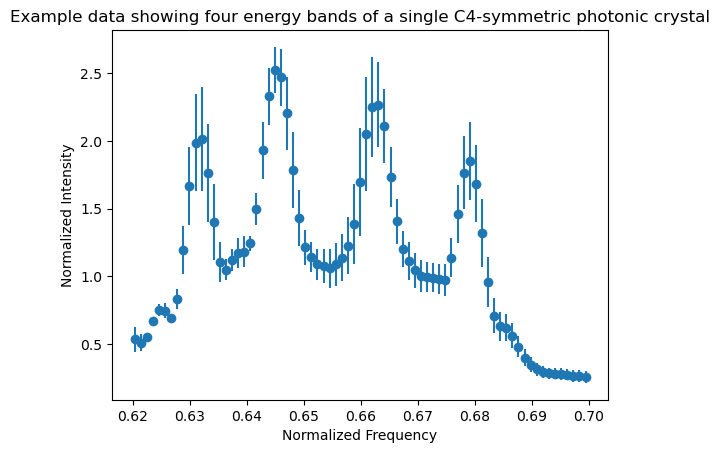

In [2]:
freq = real_data['normf'].to_numpy()
intensity = real_data['spectrum'].to_numpy()
intensity_sig = real_data['spectrum_std'].to_numpy()
plt.errorbar(freq, intensity, intensity_sig,fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')

### Inference fit using pymc

In the package, the Model.py script has two functions: Hamiltonian_model and fit_curve

$\textbf{Hamiltonian_model(data, prior_bounds)}$ function:
* It is used to define, diagonalize the Hamiltonian matrix, and build a multi Gaussian peak model from the matrix's eigenvalues. You can use this pymc model for sampling, plotting the posterior, or finding the maximum a posteriori (MAP) point to extract fit parameters.
* Its input parameters are data extracted and formatted by io.py, and a dictionary which maps parameters' names ('u11', 'u20', 'A0', 'A1', 'A2', 'A3' , 'A4', 'sigma_L') to their corresponding bounds.

$\textbf{fit_curve(freq, theta)}$ function:
 * It calculates the fitted intensity for a given set of fitting parameters
 * Its input parameters are the normalized frequency and a list of fitting parameters in the order [u11, u20, A0, A1, A2, A3, A4, sigma_L]

In [3]:
from photonic_hamiltonian import Model

#### Inference on simulated data

To test if running our model gives a reasonable result for parameter estimation, we first generate a simulated data with given values for all the parameters

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

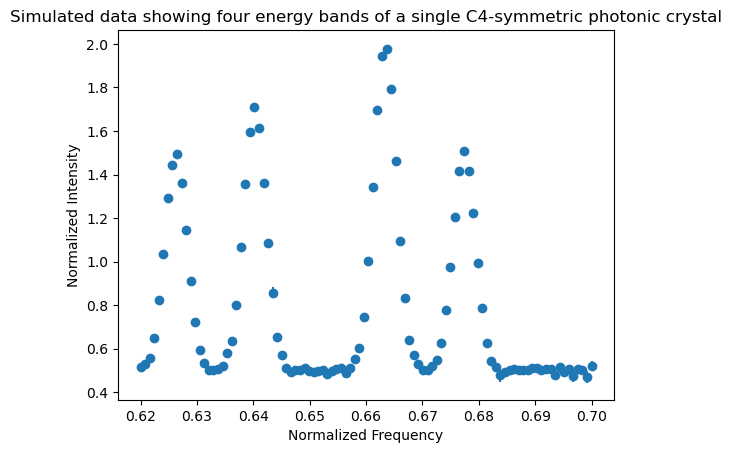

In [4]:
# Create simulated data
simu_normf = np.linspace(0.62,0.70,100)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.007
u20 = 1e-5
A0 = 0.5
A1 = 1
A2 = 1.5
A3 = 1
A4 = 1.2
sigma_L = 0.002
theta = [u11, u20, A0, A1, A2, A3, A4, sigma_L]

#create normalized intensity
line = Model.fit_curve(simu_normf, theta)

#create noise
sigma_noise = 0.01
noise = np.random.normal(0, sigma_noise, 100)

#create data array
simu_data = xr.Dataset(data_vars = {'spectrum': ('normf', line + noise),
                                  'spectrum_std': ('normf', [sigma_noise]*100)},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
plt.errorbar(simu_normf, line + noise, abs(noise), fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

From the raw data, we can guess some reasonable bounds for our priors.

In [5]:
#guess the prior bounds
simu_prior_bounds = {'u11':[0.003, 0.01], 'u20':[-1e-3, 1e-3], 'A0':[0, 1.2], 'A1':[0.5, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2,5], 'peak_width':[0.0005, 0.01]}

#create the model 
simu_ham_model = Model.Hamiltonian_model(simu_data, simu_prior_bounds)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, A0, A1, A2, A3, A4, peak_width]


Sampling 4 chains for 10 tune and 500 draw iterations (40 + 2_000 draws total) took 50 seconds.


array([[<Axes: title={'center': 'u11'}>, <Axes: title={'center': 'u11'}>],
       [<Axes: title={'center': 'u20'}>, <Axes: title={'center': 'u20'}>],
       [<Axes: title={'center': 'A0'}>, <Axes: title={'center': 'A0'}>],
       [<Axes: title={'center': 'A1'}>, <Axes: title={'center': 'A1'}>],
       [<Axes: title={'center': 'A2'}>, <Axes: title={'center': 'A2'}>],
       [<Axes: title={'center': 'A3'}>, <Axes: title={'center': 'A3'}>],
       [<Axes: title={'center': 'A4'}>, <Axes: title={'center': 'A4'}>],
       [<Axes: title={'center': 'peak_width'}>,
        <Axes: title={'center': 'peak_width'}>]], dtype=object)

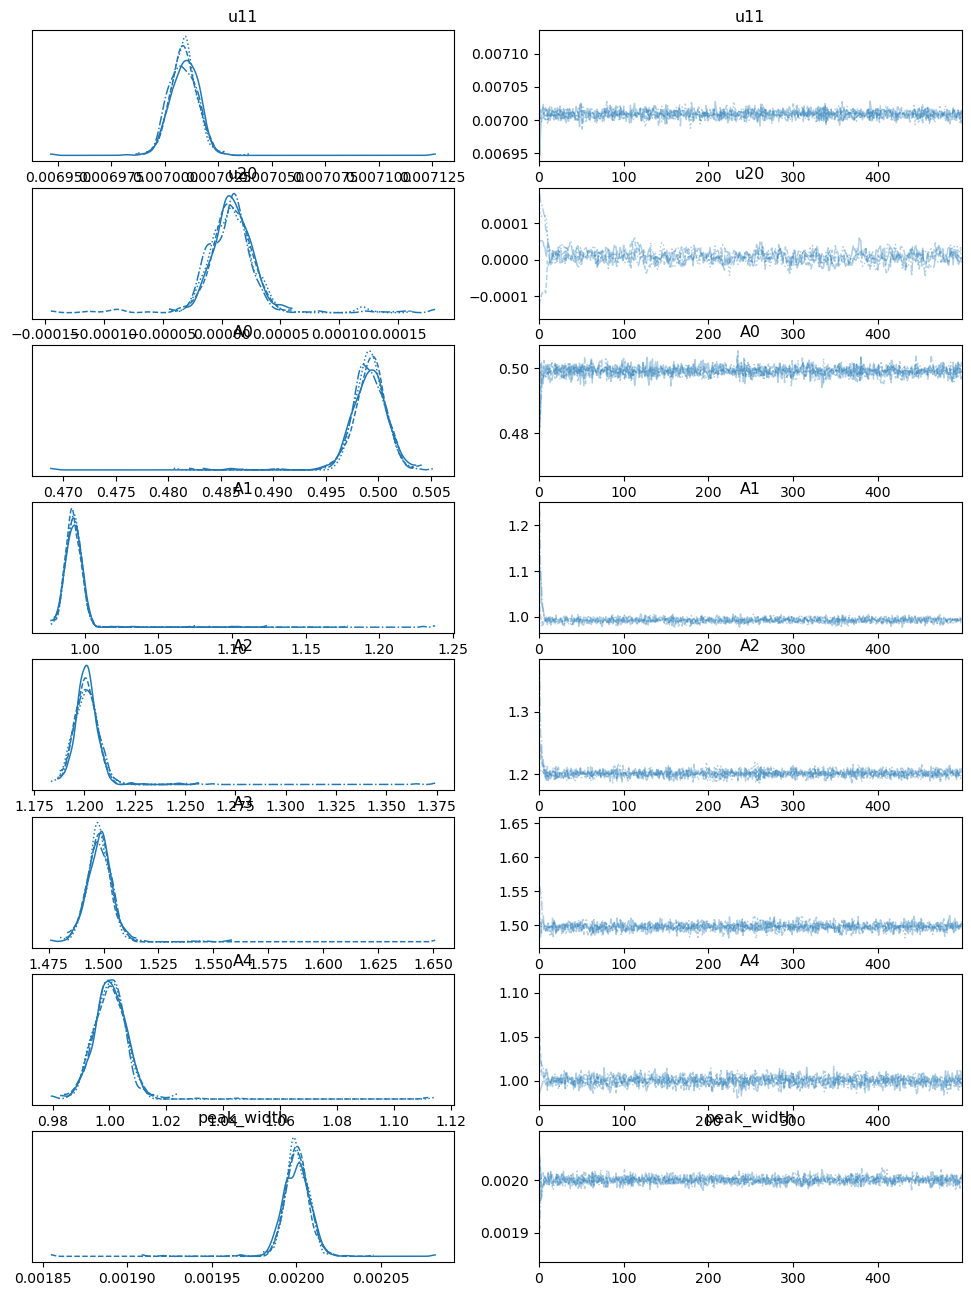

In [6]:
with simu_ham_model:
    simu_idata = pm.sample(500, tune=10)

az.plot_trace(simu_idata, figsize=(15,30));

We can see that all these marginalized posteriors are peaked at the correct values of parameters that we used to generate the simulated data. Thus, our package works reasonably well with the simulated data.

#### Inference on real data

Similar to what we did with the simulated data, we need to look at the raw data, guess the bounds for peak parameters and then sample with generative model.

In [10]:
#guess the prior bounds
prior_bounds = {'u11':[0.003, 0.01], 'u20':[-0.01, 1e-3], 'A0':[0, 1.2], 'A1':[0, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2,5], 'peak_width':[0.0005, 0.01]}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, prior_bounds)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, A0, A1, A2, A3, A4, peak_width]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 618 seconds.


array([[<Axes: title={'center': 'u11'}>, <Axes: title={'center': 'u11'}>],
       [<Axes: title={'center': 'u20'}>, <Axes: title={'center': 'u20'}>],
       [<Axes: title={'center': 'A0'}>, <Axes: title={'center': 'A0'}>],
       [<Axes: title={'center': 'A1'}>, <Axes: title={'center': 'A1'}>],
       [<Axes: title={'center': 'A2'}>, <Axes: title={'center': 'A2'}>],
       [<Axes: title={'center': 'A3'}>, <Axes: title={'center': 'A3'}>],
       [<Axes: title={'center': 'A4'}>, <Axes: title={'center': 'A4'}>],
       [<Axes: title={'center': 'peak_width'}>,
        <Axes: title={'center': 'peak_width'}>]], dtype=object)

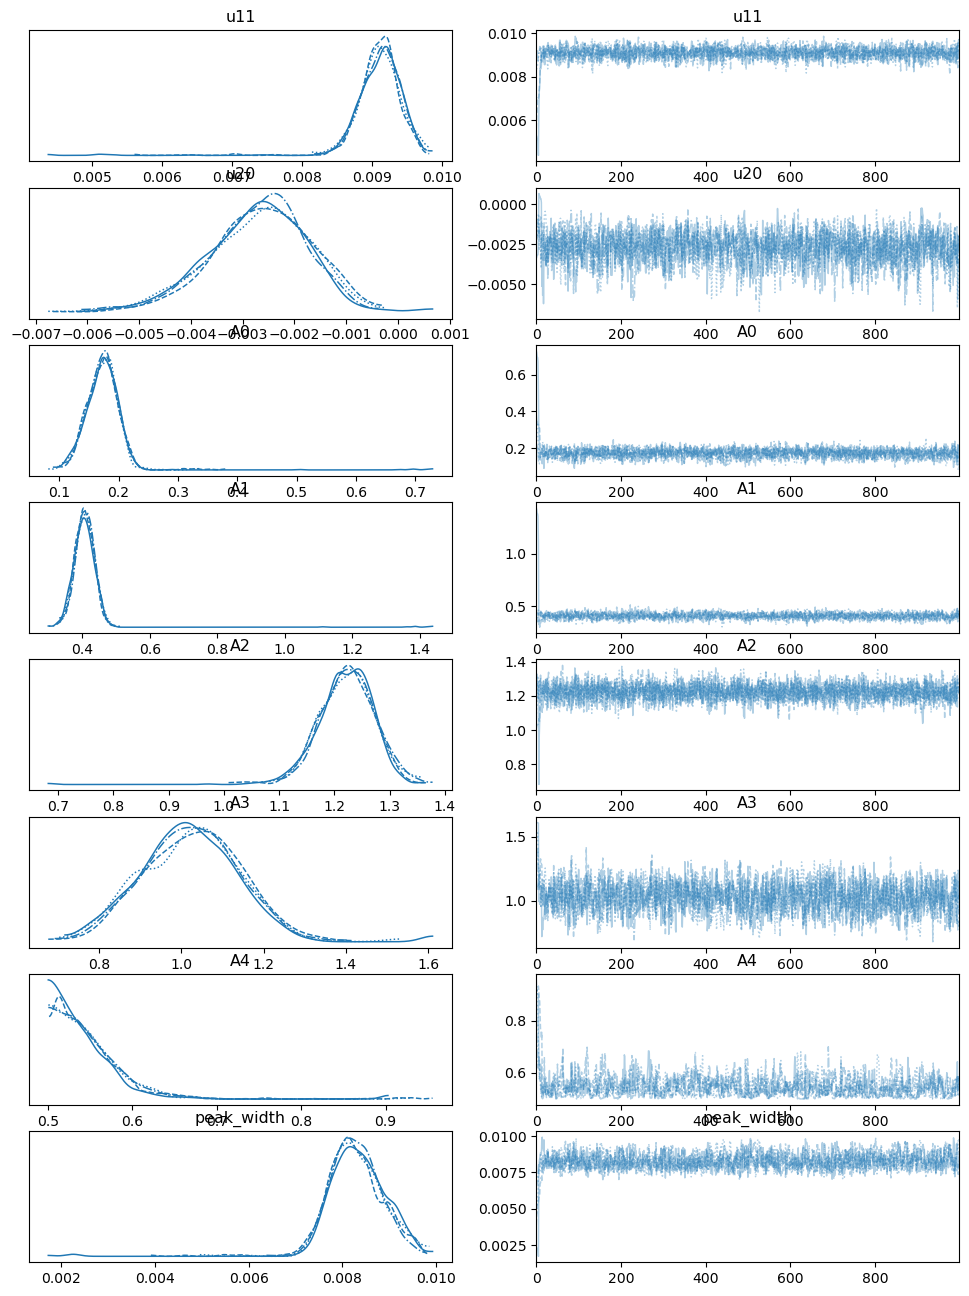

In [11]:
with ham_model:
    idata = pm.sample(1000, tune=10)

az.plot_trace(idata)

Finally, we can plot the fitted curve along with the raw data to see how our parameter estimation worked.